In [1]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# B.A.A. 10K Analysis

I recently ran the Boston Athletic Association 10K this past Sunday. Since I have a data science exam coming up, I thought this would be a good opportunity to practice some of the techniques we've been studying in class.

## Loading Data
The data used in this notebook comes from the [B.A.A. website](http://registration.baa.org/2019/cf10k/public/OverallResults10k.htm). I simply copied the contents of this page and saved it to a text file. I tried to minimize changes to the data in order to get practice reading files although I was forced to manually adjusted a handful of rows in which the spacing had been thrown off by special characters in the person's name.

In [2]:
# Load file
df = pd.read_fwf('OverallResults10k.txt', 
                 colspecs=[(0, 5),(6,9),(10,13),(14,20),
                           (24,55),(56,58),(60,61),(65,83),
                           (84,86),(97,104),(105,112)], 
                 skiprows=7,
                 header=None,
                 names=['place', 'div', 'tot', 'bib', 'name', 
                        'age', 'sex', 'city', 'st', 
                        'net_time', 'gun_time'])
df.head()

,place,div,tot,bib,name,age,sex,city,st,net_time,gun_time
0,1,1,597,10,David Bett,26,M,Kenya,NaN,28:08,28:08
1,2,1,630,6,Daniel Chebii,34,M,Kenya,NaN,28:09,28:09
2,3,2,630,8,Stephen Sambu,30,M,Kenya,NaN,28:11,28:11
3,4,1,277,30,Joseph Panga,23,M,Tanzania,NaN,28:14,28:14
4,5,2,597,11,James Ngandu,29,M,Kenya,NaN,28:42,28:42


## Statistics
### How many runners ran the 10K?
We can find this information by getting the the number of rows in our DataFrame.

In [3]:
len(df)

8003

### How did I do in the race?
Let's see how I did in the race. We can find this by getting the row in the DataFrame that contains my name.

In [4]:
df.loc[df.name == 'John Flanigan']

,place,div,tot,bib,name,age,sex,city,st,net_time,gun_time
205,206,38,597,502,John Flanigan,25,M,Boston,MA,39:47,40:07


### How did I do compared to other runners from Boston?
To find how I did compared to other runners from Boston, we'll first have to retrieve the runners from Boston from the DataFrame. We'll then assign them each a new `place` and retrieve the row containing my name again.

In [5]:
boston_runners = df.loc[df.city == 'Boston']
boston_runners.place = [x for x in range(1, len(boston_runners) + 1)]
boston_runners.loc[boston_runners.name == 'John Flanigan']

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,place,div,tot,bib,name,age,sex,city,st,net_time,gun_time
205,27,38,597,502,John Flanigan,25,M,Boston,MA,39:47,40:07


### Find the total time people spent running
To find the total time people spent running, we'll first need to get `net_time` in seconds. After that, we can calculate the total time people spent running.

In [6]:
# Convert times to seconds to make calculations simpler
def convert_time_to_seconds(time):
    split = time.split(':')
    if len(split) == 3:
        hours = int(split[0])
        minutes = int(split[1])
        seconds = int(split[2])
    elif len(split) == 2:
        hours = 0
        minutes = int(split[0])
        seconds = int(split[1])
    return hours * 3600 + minutes * 60 + seconds

df['net_time_sec'] = df.net_time.apply(convert_time_to_seconds)
df.head(5)

,place,div,tot,bib,name,age,sex,city,st,net_time,gun_time,net_time_sec
0,1,1,597,10,David Bett,26,M,Kenya,NaN,28:08,28:08,1688
1,2,1,630,6,Daniel Chebii,34,M,Kenya,NaN,28:09,28:09,1689
2,3,2,630,8,Stephen Sambu,30,M,Kenya,NaN,28:11,28:11,1691
3,4,1,277,30,Joseph Panga,23,M,Tanzania,NaN,28:14,28:14,1694
4,5,2,597,11,James Ngandu,29,M,Kenya,NaN,28:42,28:42,1722


In [7]:
days = df.net_time_sec.sum() / (60 * 60 * 24)
'{} days were spent running!'.format(days)

'343.84414351851854 days were spent running!'

# Data Visualizations

### Average Running Times
Let's plot the averge times for the top 10 cities and countries with the most runners. I originally planned to just do cities but the data provided does not distinguish between a city and a country.

In [8]:
N = 10
runners_from_cities = df.city.value_counts()
top_cities = runners_from_cities.nlargest(N).index
top_cities

Index(['Boston', 'Cambridge', 'Brookline', 'Somerville', 'India', 'Newton',
       'Brighton', 'Medford', 'China', 'Quincy'],
      dtype='object')

In [9]:
df['net_time_min'] = df.net_time_sec.apply(lambda x : math.floor(x / 60))

In [10]:
mean_net_time_by_city = df.loc[df.city.isin(top_cities)].groupby('city').net_time_min.mean()
mean_net_time_by_city

city
Boston        59.484349
Brighton      60.815789
Brookline     58.950311
Cambridge     57.655556
China         63.870370
India         70.596859
Medford       62.182609
Newton        59.376623
Quincy        63.898148
Somerville    58.645985
Name: net_time_min, dtype: float64

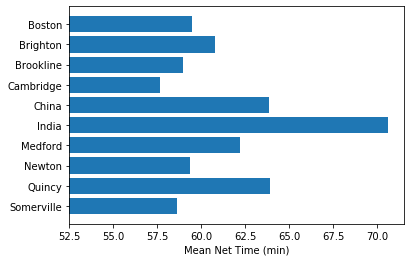

In [11]:
left = 52.5
ind = np.arange(N)
sorted_cities = mean_net_time_by_city.sort_index(ascending=False)

plt.barh(ind, sorted_cities - left, left = left, tick_label=sorted_cities.index)
plt.xlabel('Mean Net Time (min)')
plt.show()

### Place by Time Plot
Now lets try to plot the number of finishers for each minute.

In [12]:
finishers_per_minute = df.groupby('net_time_min').size()
finishers_per_minute.head()

net_time_min
28    6
29    5
30    4
31    7
32    8
dtype: int64

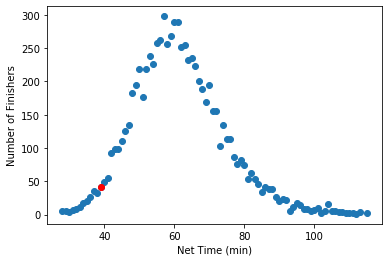

In [13]:
plt.scatter(finishers_per_minute.index, finishers_per_minute.values)
plt.scatter(39, finishers_per_minute[39], color='red')
plt.xlabel('Net Time (min)')
plt.ylabel('Number of Finishers')
plt.show()

As you can see, the resulting graph is a bell curve with a long right tail. I added a red dot to represent my finishing time.

# Linear Regression
The techniques and much of the code in this section are taken from the [_Towards Data Science_](https://towardsdatascience.com/) post, ["Train/Test Split and Cross Validation in Python"](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6), by [Adi Bronshtein](https://towardsdatascience.com/@adi.bronshtein).

First we need to clean up our data. Because `sex` is a string, the `LinearRegression` model throws an error when trying to fit the model. Our first step will be transforming this variable into something the model can use.

In [14]:
df['sex_m'] = df.sex == 'M'
df['sex_f'] = df.sex == 'F'

df.head()

,place,div,tot,bib,name,age,sex,city,st,net_time,gun_time,net_time_sec,net_time_min,sex_m,sex_f
0,1,1,597,10,David Bett,26,M,Kenya,NaN,28:08,28:08,1688,28,True,False
1,2,1,630,6,Daniel Chebii,34,M,Kenya,NaN,28:09,28:09,1689,28,True,False
2,3,2,630,8,Stephen Sambu,30,M,Kenya,NaN,28:11,28:11,1691,28,True,False
3,4,1,277,30,Joseph Panga,23,M,Tanzania,NaN,28:14,28:14,1694,28,True,False
4,5,2,597,11,James Ngandu,29,M,Kenya,NaN,28:42,28:42,1722,28,True,False


In [15]:
X = np.array(df[['age', 'sex_m', 'sex_f']])
y = np.array(df['net_time_sec'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

reg = LinearRegression().fit(X_train, y_train)
predictions = reg.predict(X_test)
predictions

array([3307.05677236, 3917.73670457, 3814.40672574, ..., 3886.73771092,
       4083.06467069, 3555.04872154])

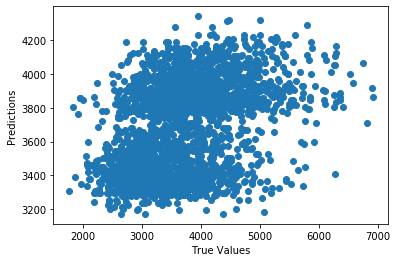

In [17]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [18]:
reg.score(X_test, y_test)

0.14245893728864334

Based on this score, our model was not very good at predicting finishing times. It seems `age` and `sex` alone are not enough to accurately predict finishing times.

### Perform same scoring with place included
If we repeat the exercise above but include the `place` a runner finished in, we should have much better results.

In [19]:
X = np.array(df[['age', 'place', 'sex_m', 'sex_f']])
y = np.array(df['net_time_sec'])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

reg = LinearRegression().fit(X_train, y_train)
predictions = reg.predict(X_test)
predictions

array([4874.64065725, 3062.95943818, 3856.62599919, ..., 4719.8049507 ,
       3730.16390535, 3710.32477936])

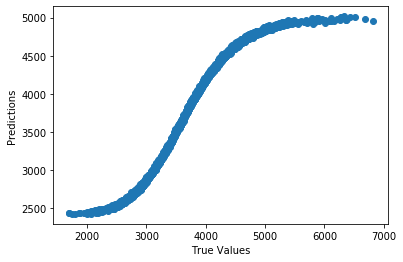

In [21]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [22]:
reg.score(X_test, y_test)

0.9290610164448602

As you can see, the model is much better at predicting net times when also given the place someone finished in. This makes sense because of the high correlation between net time and place.

### Now time to run our model
Below are 4 test cases to so we can test inputs to our model and see what times it comes back with.

In [23]:
def formatted_time(time):
    time = int(time)
    hours = math.floor(time / 3600)
    time -= hours * 3600
    
    minutes = math.floor(time / 60)
    seconds = time - (minutes * 60)
    
    return('{0:02d}:{1:02d}:{2:02d}'.format(hours, minutes, seconds))

In [24]:
# 25 year old male who placed 206
formatted_time(reg.predict(np.array([[25, 206, True, False]]))[0])

'00:41:24'

In [25]:
# 25 year old female who placed 206
formatted_time(reg.predict(np.array([[25, 206, False, True]]))[0])

'00:41:30'

In [26]:
# 65 year old male who placed 206
formatted_time(reg.predict(np.array([[65, 206, True, False]]))[0])

'00:42:22'

In [27]:
# 25 year old male who placed 4000
formatted_time(reg.predict(np.array([[25, 4000, True, False]]))[0])

'01:01:31'

In [28]:
reg.coef_

array([ 1.46675045,  0.31819285, -3.27155505,  3.27155505])

These numbers seem roughly in line with what we would expect. From these experiments, we can see that the greatest weight is given to the place someone finished in.